In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

import cv2
import scipy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

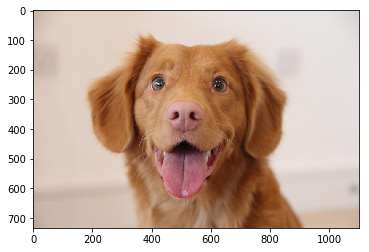

In [24]:
path = 'puppy.jpg'
image_pil = Image.open(path)
image = np.array(image_pil)
height, width, channel = image.shape

plt.imshow(image)
plt.show()

In [3]:
base_model = tf.keras.applications.vgg16.VGG16(input_shape=image.shape, include_top=False)

net=base_model.output
net=GlobalAveragePooling2D()(net)
net=Dense(1024,activation='relu')(net)
net=Dense(1024,activation='relu')(net)
net=Dense(512,activation='relu')(net)
preds=Dense(3,activation='softmax')(net)
model=Model(inputs=base_model.input,outputs=preds)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
pred = model.predict(np.expand_dims(image, 0))
pred.shape

(1, 3)

In [5]:
# 마지막 Layer의 weight 얻기
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

(512, 3)

In [6]:
# 모델이 가지고 있는 layer들 보기 
model.layers

In [26]:
# class activation map으로 표현할 마지막 Convolution의 Weight 얻기
select_layer = model.layers[-7]

In [8]:
# 모델의 새로운 output 만들기
cam_model = Model(inputs=model.input, outputs=(select_layer.output, model.layers[-1].output)) 

In [9]:
# 이미지 데이터를 예측하여 weight 얻기
features, results = cam_model.predict(np.expand_dims(image, 0))
features.shape

(1, 45, 68, 512)

In [ ]:
# 이미지의 weight 출력
features_for_one_img = features[0, :, :, :]

# 출력된 weight를 이미지와 결합하기 위하여 사이즈 조절
height_roomout = height / features_for_one_img.shape[0]
width_roomout = width / features_for_one_img.shape[1]
cam_features = scipy.ndimage.zoom(features_for_one_img, (height_roomout, width_roomout, 1), order=2)

# 예측하기
pred = np.argmax(results[0])

# 예측한 class를 강조하기 위한 weight 가져오기
cam_weights = gap_weights[:, pred]

In [16]:
cam_features.shape, cam_weights.shape

((734, 1100, 512), (512,))

In [27]:
cam_output = np.dot(cam_features, cam_weights)
cam_output.shape

(734, 1100)

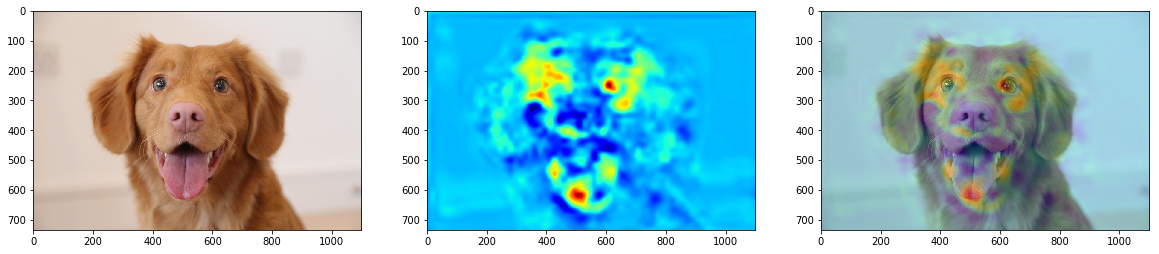

In [32]:
plt.figure(figsize=(20, 30))
plt.subplot(131)
plt.imshow(image)
plt.subplot(132)
plt.imshow(cam_output, cmap='jet')
plt.subplot(133)
plt.imshow(image)
plt.imshow(cam_output, cmap='jet', alpha=0.3)
plt.show()